In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from model import *
from data import *
from skimage import filters

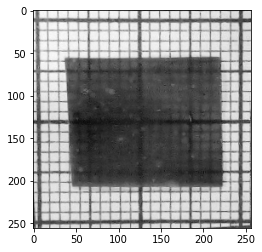

In [345]:
#image, fname = next(random_images(names=True))
image, fname = by_id(141, name=True) #323, 144, 96
img = rgb2gray(image)
img = rotate(img, find_slope(img), mode='reflect') #[60:220, 50:250]
plt.imshow(img, cmap='gray')

In [347]:
(fx, _), (fy, _) = pixel_scale(img)
fx, fy

(0.0859375, 0.0859375)

(174.70556640625, 194.683)

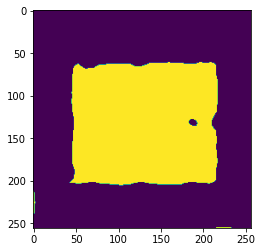

In [348]:
filtered = gabor_filter(img, fx, fy)
mask = filtered < threshold_kmeans(filtered, 3, 50)
plt.imshow(mask)
np.sum(mask)*fx*fy, DS[DS.filename == fname].area.values[0]

In [349]:
edges = {
    'normal':img,
    'sobel': filters.sobel(img),
    'roberts': filters.roberts(img),
    'scharr': filters.scharr(img),
    'farid': filters.farid(img)
}
#edges = {func:nd.gaussian_filter(arr, 2) for func, arr in edges.items()}

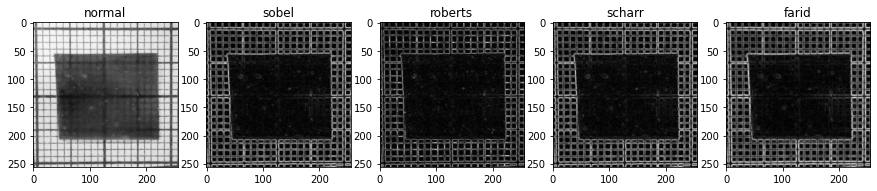

In [350]:
fig, axs = plt.subplots(1, len(edges.items()), figsize=(15, 5))
for i, (func, arr) in enumerate(edges.items()):
    axs[i].imshow(arr, cmap='gray')
    axs[i].set_title(func)
plt.show()

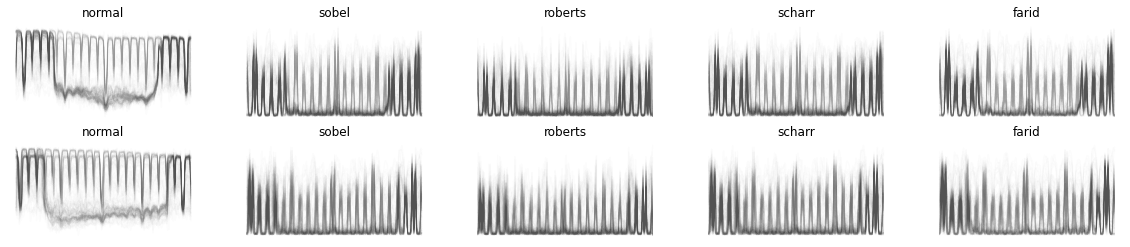

In [351]:
fig, axs = plt.subplots(2, len(edges.items()), figsize=(20, 4))
for i, (func, arr) in enumerate(edges.items()):
    axs[0][i].plot(arr, 'k-', alpha=0.01)
    axs[0][i].set_title(func)
    axs[0][i].axis('off')
    axs[1][i].plot(arr.T, 'k-', alpha=0.01)
    axs[1][i].set_title(func)
    axs[1][i].axis('off')
plt.show()

In [360]:
edges_fft = {}
fft_func = lambda y: np.fft.fftshift(np.abs(np.fft.fft(y)))
for func, arr in edges.items():
    freqs = []
    ffts = []
    Fs = []
    for dim in [arr, arr.T]:
        freq = np.fft.fftshift(np.fft.fftfreq(dim.shape[1], 1))
        fft = np.apply_along_axis(fft_func, 1, dim)
        loc = freq > 0.015
        freq = freq[loc]
        fft = fft[:, loc]
        freqs.append(freq)
        ffts.append(fft)
        Fs.append([freq[y == y.max()][0] for y in fft])
    edges_fft[func] = {
        'freqs':freqs,
        'ffts':ffts,
        'Fs':Fs
    }

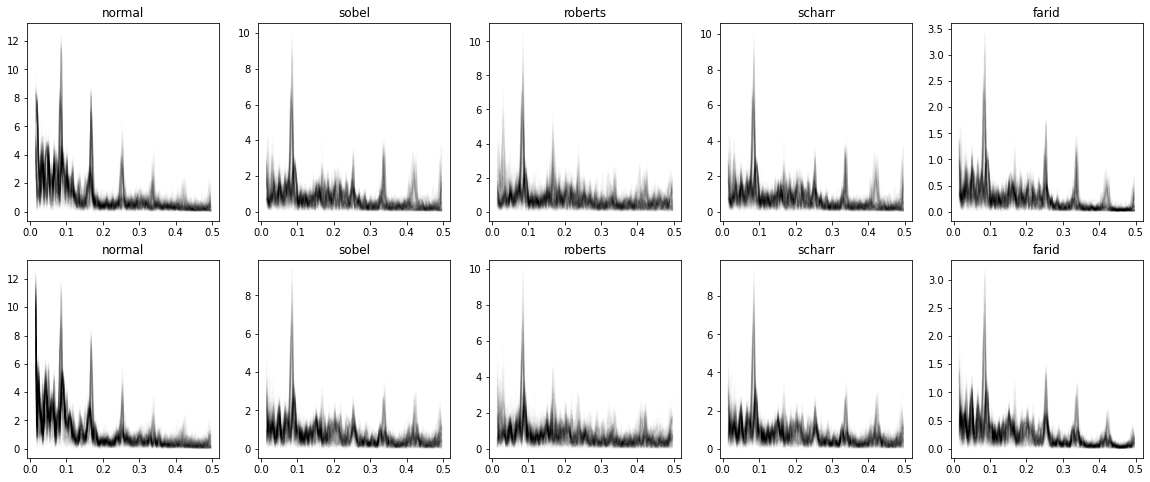

In [361]:
fig, axs = plt.subplots(2, len(edges.items()), figsize=(20, 8))
for i, (func, arr) in enumerate(edges.items()):
    freqs = edges_fft[func]['freqs']
    ffts = edges_fft[func]['ffts']
    for j in range(2):
        for y in ffts[j]:
            axs[j][i].plot(freqs[j], y, 'k-', alpha=0.01)
        axs[j][i].set_title(func)
plt.show()

normal
 0.015625
 0.015625
sobel
 0.0859375
 0.08984375
roberts
 0.09375
 0.08984375
scharr
 0.08984375
 0.08984375
farid
 0.08984375
 0.0859375


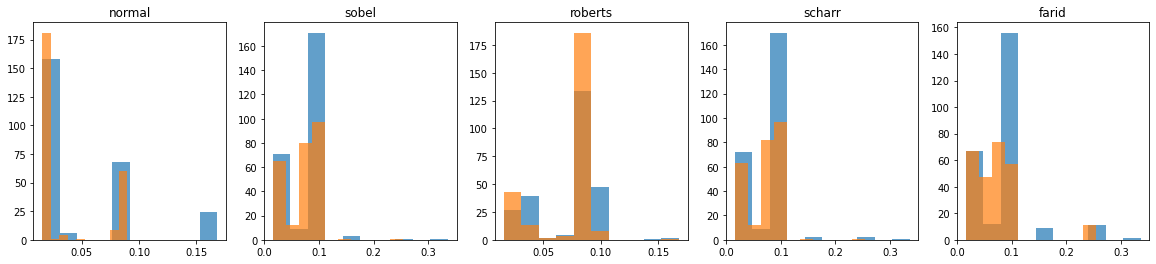

In [362]:
fig, axs = plt.subplots(1, len(edges.items()), figsize=(20, 4))
fs = {}
for i, (func, arr) in enumerate(edges.items()):
    #axs[i].hist(edges_fft[func]['Fs'])
    print(func)
    fs[func] = []
    for F in edges_fft[func]['Fs']:
        axs[i].hist(F, alpha=0.7)
        #f, counts = np.unique(np.round(F, 5), return_counts=True)
        #fs[func].append(f[counts == np.sort(counts)[-1]][0])
        fs[func].append(mode(F).mode[0])
        print('', fs[func][-1])
    axs[i].set_title(func)
plt.show()

(183.0767857152, 194.683)

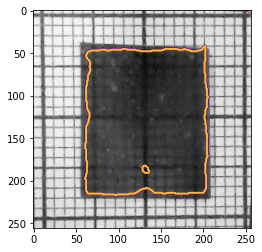

In [306]:
fx, fy = fs['sobel']
filtered = gabor_filter(img, fx, fy)
mask = filtered < threshold_kmeans(filtered, 3, 50)
plt.imshow(img, cmap='gray')
plt.contour(mask, cmap='plasma')
np.sum(mask)*fx*fy, DS[DS.filename == fname].area.values[0]

In [365]:
def pixel_scale_edge(img):
    arr = filters.sobel(img)
    fs = []
    for dim in [arr, arr.T]:
        freq = np.fft.fftshift(np.fft.fftfreq(dim.shape[1], 1))
        fft = np.apply_along_axis(fft_func, 1, dim)
        loc = freq > 0.015
        freq = freq[loc]
        fft = fft[:, loc]
        F = [freq[y == y.max()][0] for y in fft]
        fs.append(mode(F).mode[0])
        #f, counts = np.unique(np.round(F, 5), return_counts=True)
        #f[counts == np.sort(counts)[-1]][0]
    return fs

pixel_scale_edge(img)

[0.0859375, 0.08984375]

In [366]:
n_imgs = len(DS)
Fs = {'fx':[], 'fy':[]}
for i, filename in enumerate(DS.filename.values):
    img = rgb2gray(get(filename))
    img = rotate(img, find_slope(img), mode='reflect')
    fx, fy = pixel_scale_edge(img)
    Fs['fx'].append(fx)
    Fs['fy'].append(fy)
    print(f'{(i+1)/n_imgs*100:.2f}%', end='\r')

In [367]:
Fs = pd.DataFrame(Fs)
Fs

fx        fy
0    0.066406  0.066406
1    0.097656  0.097656
2    0.089844  0.089844
3    0.093750  0.089844
4    0.050781  0.050781
..        ...       ...
350  0.070312  0.070312
351  0.074219  0.074219
352  0.070312  0.070312
353  0.074219  0.074219
354  0.074219  0.074219

[355 rows x 2 columns]

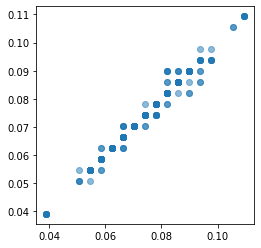

In [368]:
fig, ax = plt.subplots()
plt.plot(Fs.fx, Fs.fy, 'o', alpha=0.5)
ax.set_aspect('equal')

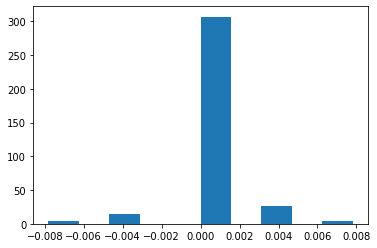

In [370]:
Fs['df'] = Fs.fx - Fs.fy
plt.hist(Fs.df)
plt.show()

In [375]:
Fs.df.abs().unique()

array([0.        , 0.00390625, 0.0078125 ])

In [376]:
Fs.df.abs().unique()/Fs.df.abs().unique()[1]

array([0., 1., 2.])

In [378]:
DS['Ap'] = Fs.fx*Fs.fy
DS

filename     area        Ap
0      0.jpg  100.473  0.004410
1      1.jpg  127.880  0.009537
2      2.jpg  161.820  0.008072
3      3.jpg  190.003  0.008423
4      4.jpg   22.713  0.002579
..       ...      ...       ...
350  350.jpg   98.599  0.004944
351  351.jpg   98.599  0.005508
352  352.jpg   98.599  0.004944
353  353.jpg   98.599  0.005508
354  354.jpg   98.599  0.005508

[355 rows x 3 columns]

In [379]:
DS.to_csv(os.path.join(PATH, 'dataset.csv'))